# Plan Analytics for Medications vs Gender
This script is for planning the analytics for the focus question: What, if any, relationship exists between __medications given__ and __genders of patient and provider__?

_Author: Jared Gauntt_

In [1]:
#Import libraries
import pandas as pd
import matplotlib.pyplot as plt

## Dataset

### Assumptions
This script reads in the joined Patients and Medications dataset from the data/02_intermediate folder. Each row represents a single instance of a medication given to a patient. If a single patient is given one medication multiple times, that would be reflected as multiple rows in this dataset.

FRDPersonnelID 9E5D40DC-5DC6-E411-80C7-001DD8B71D38 had many duplicate records in the raw Medications dataset that could be removed per our FCFRD partners. These duplicates were removed prior to the joining process.

Rows in the raw Patients dataset with null Provider Gender or Provider Start Date were dropped prior to the joining process. Rows with null Patient Gender were retained for the other focus question using this dataset. Null Patient Gender rows will need to be removed prior to this analysis.

### Import and Inspect Data

In [2]:
#Import CSV
localFolder='../data/02_intermediate/' #If run from Git Hub project folder structure, script must be in "notebooks" folder
fileName='MedicationsPatients-20210225-ems-raw-v04.csv'
columnsToUse=['PatientId','PatientGender','PatientGenderCode',
            'FRDPersonnelID','FRDPersonnelGender','ProviderGenderCode',
            'Medication_Given_RXCUI_Code','Medication_Given_Description']
dfAll=pd.read_csv(localFolder+fileName, usecols=columnsToUse)[columnsToUse]

In [3]:
#Import Medication Classes
medicationClasses=pd.read_csv(localFolder+'MedicationGroups.csv',usecols=['Medication_Given_RXCUI_Code','MedicationGroup'])

In [4]:
#Calculate number of rows
len(dfAll)

62881

In [5]:
#Calculate number of unique values per column
dfAll.nunique(dropna=False)

PatientId                       38389
PatientGender                       4
PatientGenderCode                   4
FRDPersonnelID                    844
FRDPersonnelGender                  2
ProviderGenderCode                  2
Medication_Given_RXCUI_Code        33
Medication_Given_Description       33
dtype: int64

In [6]:
#Calculate number of nulls per column
dfAll.isnull().sum()

PatientId                        0
PatientGender                   32
PatientGenderCode                0
FRDPersonnelID                   0
FRDPersonnelGender               0
ProviderGenderCode               0
Medication_Given_RXCUI_Code      6
Medication_Given_Description     6
dtype: int64

Since the null values for PatientGender and Medication represent a negligible portion of the records, they will be removed prior to analysis. We can bring the 6 null medications to our FCFRD partners' attention.

In [7]:
#Confirm Patient Gender values
dfAll['PatientGender'].value_counts(dropna=False)

Male                             32536
Female                           30289
NaN                                 32
Unknown (Unable to Determine)       24
Name: PatientGender, dtype: int64

Since the Unknown category represents a neglibile portion of the records, they will be removed prior to analysis. This will be noted in the report.

In [8]:
#Reduce to unique Patients and count gender
dfAll[['PatientId','PatientGender']].drop_duplicates()['PatientGender'].value_counts()

Male                             19312
Female                           19039
Unknown (Unable to Determine)       16
Name: PatientGender, dtype: int64

Male and female patients are balanced.

In [9]:
#Confirm Provider Gender values
dfAll['FRDPersonnelGender'].value_counts(dropna=False)

Male      52356
Female    10525
Name: FRDPersonnelGender, dtype: int64

In [10]:
#Reduce to unique Providers and count gender
dfAll[['FRDPersonnelID','FRDPersonnelGender']].drop_duplicates()['FRDPersonnelGender'].value_counts()

Male      695
Female    149
Name: FRDPersonnelGender, dtype: int64

When performing analysis on Provider Gender, we will have to be careful to account for the large imbalance between number of male and female providers.

### Reduce Data

In [11]:
#Remove all rows with any nulls
dfReduced=dfAll.loc[dfAll.isnull().sum(axis=1)==0,:]

#Remove unknown category for PatientGender
dfReduced=dfReduced.loc[dfReduced['PatientGender']!='Unknown (Unable to Determine)',:]

#Calculate percentage of dataset remaining
len(dfReduced)/len(dfAll)*100

99.90140105914345

### Add common columns

In [12]:
#Add a column for Medication Class
dfReduced=dfReduced.merge(medicationClasses,how='left',on='Medication_Given_RXCUI_Code')

#Add a column that specifies the Provider-Patient gender relationship
dfReduced['GenderRelationship']=dfReduced['FRDPersonnelGender'].str.cat(dfReduced['PatientGender'],sep=' treat ')

## Prepare Processed Datasets

### Prepare dataframe where each row is unique Patient/Provider interaction (one or more medications given)

In [13]:
def CreateInteractionsDataFrame(df,medicationClassesToDrop):

    #Drop specific medication classes
    df=df.loc[~df['MedicationGroup'].isin(medicationClassesToDrop),:]
    
    #Determine the unique interactions (Provider to Patient) independent of number/types of medications given during that interaction
    dfInteractions=df[['PatientId','PatientGender','FRDPersonnelID','FRDPersonnelGender','GenderRelationship']].drop_duplicates()

    #Calculate the number of rows per each Patient/Provider pair
    dfNumRowsPerPatientProviderPair=df.groupby(['PatientId','FRDPersonnelID'],as_index=False).size()
    dfNumRowsPerPatientProviderPair.rename(columns={'size':'NumMedicationsGiven'},inplace=True)
    dfInteractions=dfInteractions.merge(dfNumRowsPerPatientProviderPair,how='inner',on=['PatientId','FRDPersonnelID'])

    #Calculate the number of rows per each Patient/Provider/Medication triplet
    dfNumRowsPerPatientProviderMedicationTriplet=df[['PatientId','FRDPersonnelID','Medication_Given_RXCUI_Code']].drop_duplicates().groupby(
        ['PatientId','FRDPersonnelID'],as_index=False).size()
    dfNumRowsPerPatientProviderMedicationTriplet.rename(columns={'size':'NumUniqueMedicationsGiven'},inplace=True)
    dfInteractions=dfInteractions.merge(dfNumRowsPerPatientProviderMedicationTriplet,how='inner',on=['PatientId','FRDPersonnelID'])

    #Add a column that characterizes whether at least one medication was given more than once on a call
    dfInteractions['MultiplesOfMedicationGiven']=(dfInteractions['NumMedicationsGiven']!=dfInteractions['NumUniqueMedicationsGiven'])

    return(dfInteractions)

dfInteractions=CreateInteractionsDataFrame(dfReduced,[])
dfInteractionsNoGeneral=CreateInteractionsDataFrame(dfReduced,['General'])

### Prepare dataframe where each row is a unique Medication

In [14]:
#Determine number of records
dfMedications=pd.DataFrame(pd.Series(dfReduced['Medication_Given_Description'].value_counts(),name='Number of Doses Given'))


##########################    PATIENTS    ##########################

#Number of patients per unique medication
dfMedications_UniquePatients=dfReduced[['PatientId','PatientGender','Medication_Given_Description']].drop_duplicates()[
    ['Medication_Given_Description','PatientGender']]
dsNumMalePatients=pd.Series(dfMedications_UniquePatients.loc[dfMedications_UniquePatients['PatientGender']=='Male',
    'Medication_Given_Description'].value_counts(),name='Number of Male Patients')
dsNumFemalePatients=pd.Series(dfMedications_UniquePatients.loc[dfMedications_UniquePatients['PatientGender']=='Female',
    'Medication_Given_Description'].value_counts(),name='Number of Female Patients')
dfMedications=pd.merge(dfMedications,dsNumMalePatients,how='left',left_index=True,right_index=True)
dfMedications=pd.merge(dfMedications,dsNumFemalePatients,how='left',left_index=True,right_index=True)

#Gender percentage of Patients receiving medication
dfMedications.fillna(0,inplace=True)
dsTotalPatients=dfMedications['Number of Male Patients']+dfMedications['Number of Female Patients']
dfMedications['Dist Male Patients']=round(dfMedications['Number of Male Patients']/dsTotalPatients*100,1)
dfMedications['Dist Female Patients']=round(dfMedications['Number of Female Patients']/dsTotalPatients*100,1)

#Number of patients (wrt gender) per medication left/right centerline
patientCount=dfReduced[['PatientId','PatientGender']].drop_duplicates()['PatientGender'].value_counts()
centerlinePercentMalePatients=patientCount['Male']/(patientCount.sum())
dfMedications['Number of Patients from Centerline']=abs(dfMedications['Number of Male Patients']-(
    dfMedications['Number of Male Patients']+dfMedications['Number of Female Patients'])*centerlinePercentMalePatients)


##########################    PROVIDERS    ##########################

#Number of providers per unique medication
dfMedications_UniqueProviders=dfReduced[['FRDPersonnelID','FRDPersonnelGender','Medication_Given_Description']].drop_duplicates()[
    ['Medication_Given_Description','FRDPersonnelGender']]
dsNumMaleProviders=pd.Series(dfMedications_UniqueProviders.loc[dfMedications_UniqueProviders['FRDPersonnelGender']=='Male',
    'Medication_Given_Description'].value_counts(),name='Number of Male Providers')
dsNumFemaleProviders=pd.Series(dfMedications_UniqueProviders.loc[dfMedications_UniqueProviders['FRDPersonnelGender']=='Female',
    'Medication_Given_Description'].value_counts(),name='Number of Female Providers')
dfMedications=pd.merge(dfMedications,dsNumMaleProviders,how='left',left_index=True,right_index=True)
dfMedications=pd.merge(dfMedications,dsNumFemaleProviders,how='left',left_index=True,right_index=True)

#Gender percentage of Providers giving medication
dfMedications.fillna(0,inplace=True)
dsTotalProviders=dfMedications['Number of Male Providers']+dfMedications['Number of Female Providers']
dfMedications['Dist Male Providers']=round(dfMedications['Number of Male Providers']/dsTotalProviders*100,1)
dfMedications['Dist Female Providers']=round(dfMedications['Number of Female Providers']/dsTotalProviders*100,1)

#Number of providers (wrt gender) per medication left/right centerline
providerCount=dfReduced[['FRDPersonnelID','FRDPersonnelGender']].drop_duplicates()['FRDPersonnelGender'].value_counts()
centerlinePercentMaleProviders=providerCount['Male']/(providerCount.sum())
dfMedications['Number of Providers from Centerline']=abs(dfMedications['Number of Male Providers']-(
    dfMedications['Number of Male Providers']+dfMedications['Number of Female Providers'])*centerlinePercentMaleProviders)


##########################    INTERACTIONS    ##########################

#Number of interactions per unique medication
dfMedications_UniqueInteractions=dfReduced[['PatientId','FRDPersonnelID','GenderRelationship','Medication_Given_Description']].drop_duplicates()[
    ['Medication_Given_Description','GenderRelationship']].groupby(['Medication_Given_Description','GenderRelationship'],as_index=False).size()
dfMedications_UniqueInteractions=dfMedications_UniqueInteractions.pivot(index='Medication_Given_Description',columns='GenderRelationship').fillna(0)
dfMedications_UniqueInteractions.columns=dfMedications_UniqueInteractions.columns.droplevel(0)
dfMedications=pd.merge(dfMedications,dfMedications_UniqueInteractions,how='left',left_index=True,right_index=True)

#Gender percentage of Patients receiving medication by Female Provider
dsFemaleTreat=dfMedications['Female treat Female']+dfMedications['Female treat Male']
dfMedications['Female Provider Dist of Male Patients']=round(dfMedications['Female treat Male']/dsFemaleTreat*100,1)
dfMedications['Female Provider Dist of Female Patients']=round(dfMedications['Female treat Female']/dsFemaleTreat*100,1)

#Number of interactions (wrt gender) per medication left/right centerline
interactionCount=dfReduced[['PatientId','FRDPersonnelID','GenderRelationship']].drop_duplicates()['GenderRelationship'].value_counts()
centerlinePercentFemaleProvidersTreatMales=interactionCount['Female treat Male']/(interactionCount['Female treat Male']+interactionCount['Female treat Female'])
dfMedications['Number of Female Provider Interactions from Centerline']=abs(dfMedications['Female treat Male']-(
    dfMedications['Female treat Male']+dfMedications['Female treat Female'])*centerlinePercentFemaleProvidersTreatMales)

#Gender percentage of Patients receiving medication by Male Provider
dsMaleTreat=dfMedications['Male treat Female']+dfMedications['Male treat Male']
dfMedications['Male Provider Dist of Male Patients']=round(dfMedications['Male treat Male']/dsMaleTreat*100,1)
dfMedications['Male Provider Dist of Female Patients']=round(dfMedications['Male treat Female']/dsMaleTreat*100,1)

#Number of interactions (wrt gender) per medication left/right centerline
centerlinePercentMaleProvidersTreatMales=interactionCount['Male treat Male']/(interactionCount['Male treat Male']+interactionCount['Male treat Female'])
dfMedications['Number of Male Provider Interactions from Centerline']=abs(dfMedications['Male treat Male']-(
    dfMedications['Male treat Male']+dfMedications['Male treat Female'])*centerlinePercentMaleProvidersTreatMales)

### Prepare dataframe where each row is a unique Medication Class

In [15]:
#Determine number of records
dfMedicationClasses=pd.DataFrame(pd.Series(dfReduced['MedicationGroup'].value_counts(),name='Number of Doses Given'))


##########################    PATIENTS    ##########################

#Number of patients per unique medication
dfMedicationClasses_UniquePatients=dfReduced[['PatientId','PatientGender','MedicationGroup']].drop_duplicates()[
    ['MedicationGroup','PatientGender']]
dsNumMalePatients=pd.Series(dfMedicationClasses_UniquePatients.loc[dfMedicationClasses_UniquePatients['PatientGender']=='Male',
    'MedicationGroup'].value_counts(),name='Number of Male Patients')
dsNumFemalePatients=pd.Series(dfMedicationClasses_UniquePatients.loc[dfMedicationClasses_UniquePatients['PatientGender']=='Female',
    'MedicationGroup'].value_counts(),name='Number of Female Patients')
dfMedicationClasses=pd.merge(dfMedicationClasses,dsNumMalePatients,how='left',left_index=True,right_index=True)
dfMedicationClasses=pd.merge(dfMedicationClasses,dsNumFemalePatients,how='left',left_index=True,right_index=True)

#Gender percentage of Patients receiving medication
dfMedicationClasses.fillna(0,inplace=True)
dsTotalPatients=dfMedicationClasses['Number of Male Patients']+dfMedicationClasses['Number of Female Patients']
dfMedicationClasses['Dist Male Patients']=round(dfMedicationClasses['Number of Male Patients']/dsTotalPatients*100,1)
dfMedicationClasses['Dist Female Patients']=round(dfMedicationClasses['Number of Female Patients']/dsTotalPatients*100,1)

#Number of patients (wrt gender) per medication left/right centerline
dfMedicationClasses['Number of Patients from Centerline']=abs(dfMedicationClasses['Number of Male Patients']-(
    dfMedicationClasses['Number of Male Patients']+dfMedicationClasses['Number of Female Patients'])*centerlinePercentMalePatients)


##########################    PROVIDERS    ##########################

#Number of providers per unique medication
dfMedicationClasses_UniqueProviders=dfReduced[['FRDPersonnelID','FRDPersonnelGender','MedicationGroup']].drop_duplicates()[
    ['MedicationGroup','FRDPersonnelGender']]
dsNumMaleProviders=pd.Series(dfMedicationClasses_UniqueProviders.loc[dfMedicationClasses_UniqueProviders['FRDPersonnelGender']=='Male',
    'MedicationGroup'].value_counts(),name='Number of Male Providers')
dsNumFemaleProviders=pd.Series(dfMedicationClasses_UniqueProviders.loc[dfMedicationClasses_UniqueProviders['FRDPersonnelGender']=='Female',
    'MedicationGroup'].value_counts(),name='Number of Female Providers')
dfMedicationClasses=pd.merge(dfMedicationClasses,dsNumMaleProviders,how='left',left_index=True,right_index=True)
dfMedicationClasses=pd.merge(dfMedicationClasses,dsNumFemaleProviders,how='left',left_index=True,right_index=True)

#Gender percentage of Providers giving medication
dfMedicationClasses.fillna(0,inplace=True)
dsTotalProviders=dfMedicationClasses['Number of Male Providers']+dfMedicationClasses['Number of Female Providers']
dfMedicationClasses['Dist Male Providers']=round(dfMedicationClasses['Number of Male Providers']/dsTotalProviders*100,1)
dfMedicationClasses['Dist Female Providers']=round(dfMedicationClasses['Number of Female Providers']/dsTotalProviders*100,1)

#Number of providers (wrt gender) per medication left/right centerline
dfMedicationClasses['Number of Providers from Centerline']=abs(dfMedicationClasses['Number of Male Providers']-(
    dfMedicationClasses['Number of Male Providers']+dfMedicationClasses['Number of Female Providers'])*centerlinePercentMaleProviders)


##########################    INTERACTIONS    ##########################

#Number of interactions per unique medication
dfMedicationClasses_UniqueInteractions=dfReduced[['PatientId','FRDPersonnelID','GenderRelationship','MedicationGroup']].drop_duplicates()[
    ['MedicationGroup','GenderRelationship']].groupby(['MedicationGroup','GenderRelationship'],as_index=False).size()
dfMedicationClasses_UniqueInteractions=dfMedicationClasses_UniqueInteractions.pivot(index='MedicationGroup',columns='GenderRelationship').fillna(0)
dfMedicationClasses_UniqueInteractions.columns=dfMedicationClasses_UniqueInteractions.columns.droplevel(0)
dfMedicationClasses=pd.merge(dfMedicationClasses,dfMedicationClasses_UniqueInteractions,how='left',left_index=True,right_index=True)

#Gender percentage of Patients receiving medication by Female Provider
dsFemaleTreat=dfMedicationClasses['Female treat Female']+dfMedicationClasses['Female treat Male']
dfMedicationClasses['Female Provider Dist of Male Patients']=round(dfMedicationClasses['Female treat Male']/dsFemaleTreat*100,1)
dfMedicationClasses['Female Provider Dist of Female Patients']=round(dfMedicationClasses['Female treat Female']/dsFemaleTreat*100,1)

#Number of interactions (wrt gender) per medication left/right centerline
dfMedicationClasses['Number of Female Provider Interactions from Centerline']=abs(dfMedicationClasses['Female treat Male']-(
    dfMedicationClasses['Female treat Male']+dfMedicationClasses['Female treat Female'])*centerlinePercentFemaleProvidersTreatMales)

#Gender percentage of Patients receiving medication by Male Provider
dsMaleTreat=dfMedicationClasses['Male treat Female']+dfMedicationClasses['Male treat Male']
dfMedicationClasses['Male Provider Dist of Male Patients']=round(dfMedicationClasses['Male treat Male']/dsMaleTreat*100,1)
dfMedicationClasses['Male Provider Dist of Female Patients']=round(dfMedicationClasses['Male treat Female']/dsMaleTreat*100,1)

#Number of interactions (wrt gender) per medication left/right centerline
dfMedicationClasses['Number of Male Provider Interactions from Centerline']=abs(dfMedicationClasses['Male treat Male']-(
    dfMedicationClasses['Male treat Male']+dfMedicationClasses['Male treat Female'])*centerlinePercentMaleProvidersTreatMales)

## Visualization Functions

In [16]:
def TripleBar(df,figureTitle,
              personType,personGenderCount,
              genderLeft,colDistLeft,colNumLeft,
              genderRight,colDistRight,colNumRight,
              colNumFromVerticalLine,colSort):

    #Initialize figure
    fig=plt.figure(figsize=(15,11))

    #Sort indicies
    if colSort==0:
        df.sort_values(by=colDistLeft,inplace=True)
    elif colSort==1:
        df.sort_values(by=colNumLeft,inplace=True)
    elif colSort==2:
        df.sort_values(by=colNumFromVerticalLine,inplace=True)
    else:
        print('Invalid sort column')
        return()

    #Percent of People
    ax1=plt.subplot(131)
    ax1.barh(y=df.index,width=df[colDistLeft])
    ax1.barh(y=df.index,width=df[colDistRight],left=df[colDistLeft])
    ax1.set_xlabel('Percent of '+personType+'\n(Vertical Black Line = Distribution of All '+personType+')',fontsize=12)
    ax1.axvline(x=personGenderCount[genderLeft]/(personGenderCount[genderLeft]+personGenderCount[genderRight])*100,color='black')

    #Number of People
    ax2=plt.subplot(132)
    ax2.barh(y=df.index,width=df[colNumLeft])
    ax2.barh(y=df.index,width=df[colNumRight],left=df[colNumLeft])
    ax2.set_xlabel('Number of '+personType,fontsize=12)
    ax2.set_yticklabels([])
    ax2.legend([genderLeft+' '+personType,genderRight+' '+personType])

    #Left/right of vertical line
    ax3=plt.subplot(133)
    ax3.barh(y=df.index,width=df[colNumFromVerticalLine],color='green')
    ax3.set_xlabel('Number of '+personType+' Left/Right of Vertical Line',fontsize=12)
    ax3.set_yticklabels([])            

    #Title
    fig.suptitle(figureTitle,fontsize=18,y=0.92)
    plt.show()

In [17]:
def VertBars(df,colCount,
             genderLL,genderLR,genderRL,genderRR,
             figureTitle):

    #For each unique interaction (Provider to Patient), plot the gender relationship
    setBins=list(range(1,df[colCount].max()+1))
    fig=plt.figure(figsize=(12,4))

    #Male Providers
    ax1=plt.subplot(121)
    ax1.hist([df.loc[df['GenderRelationship']==genderLL,colCount],
            df.loc[dfInteractions['GenderRelationship']==genderLR,colCount]],
            label=[genderLL,genderLR],bins=setBins)
    ax1.set_xticks(setBins)
    ax1.set_xlabel('Number of Medications Given')
    ax1.set_ylabel('Number of Interactions')
    ax1.legend(loc='upper right')

    #Female Providers
    ax2=plt.subplot(122)
    ax2.hist([df.loc[df['GenderRelationship']==genderRL,colCount],
            df.loc[df['GenderRelationship']==genderRR,colCount]],
            label=[genderRL,genderRR],bins=setBins)
    ax2.set_xticks(setBins)
    ax2.set_xlabel('Number of Medications Given')
    ax2.set_ylabel('Number of Interactions')
    ax2.legend(loc='upper right')

    #Title
    fig.suptitle(figureTitle,fontsize=18)

    #Show
    plt.show()

## Analysis

Are some medications given more to a certain Patient Gender?
- Triple Bar Plot (all providers) - COMPLETE
- Triple Bar Plot (male providers) - IMPLEMENTED / NEED TO TEST
- Triple Bar Plot (female providers) - IMPLEMENTED / NEED TO TEST

Are some classes of medication given more to a certain Patient Gender?
- Triple Bar Plot (all providers) - IMPLEMENTED / NEED TO TEST
- Triple Bar Plot (male providers) - IMPLEMENTED / NEED TO TEST
- Triple Bar Plot (female providers) - IMPLEMENTED / NEED TO TEST

Are some medications given more by a certain Provider Gender? _(might retire if the separation of Patient triple plots by provider gender proves more useful)_
- Triple Bar Plot (all patients) - COMPLETE

Are some classes of medication given more by a certain Patient Gender? _(might retire if the separation of Patient triple plots by provider gender proves more useful)_
- Triple Bar Plot (all patients) - IMPLEMENTED / NEED TO TEST

Are the number of medications given related to the relationship between Provider and Patient Gender?
- Vert Bars - COMPLETE
- Vert Bars (less oxygen and saline) - COMPLETE

Are the number of unique medications given related to the relationship between Provider and Patient Gender?
- Vert Bars - COMPLETE
- Vert Bars (less oxygen and saline) - COMPLETE

Are Providers likely to give medications to both Patient genders or are they biased towards a particular gender? _(useful background, will not analyze further)_
- COMPLETE

Is giving a unique medication more than once related to the relationship between Provider and Patient Gender?
- COMPLETE

### Are some medications given more to a certain gender patient?

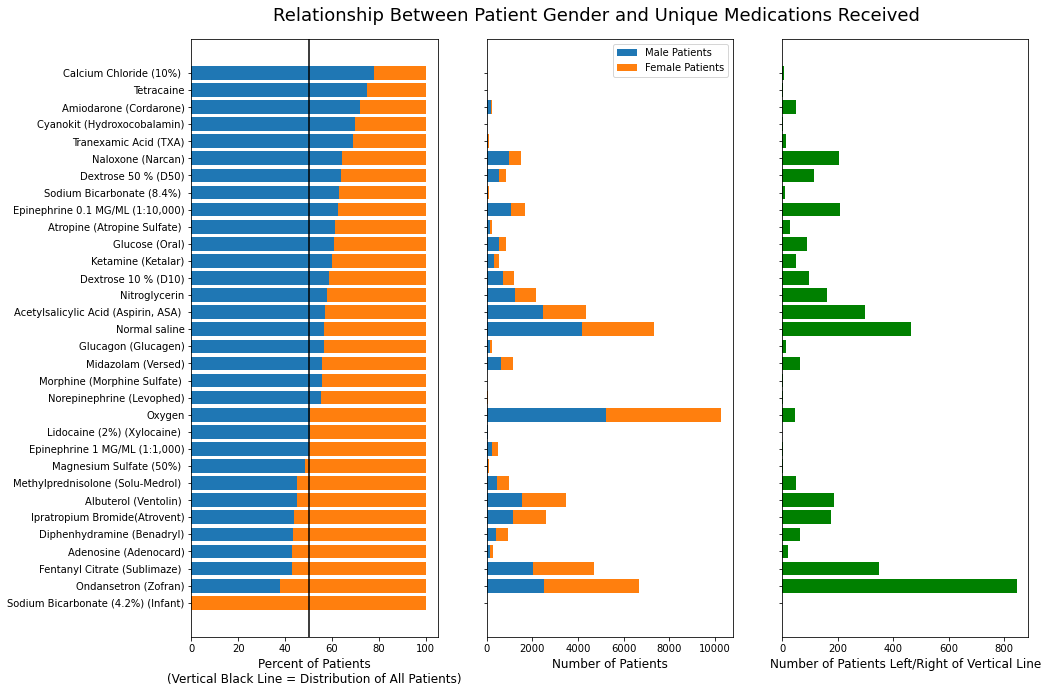

In [18]:
TripleBar(dfMedications,'Relationship Between Patient Gender and Unique Medications Received',
          'Patients',patientCount,
          'Male','Dist Male Patients','Number of Male Patients',
          'Female','Dist Female Patients','Number of Female Patients',
          'Number of Patients from Centerline',0)

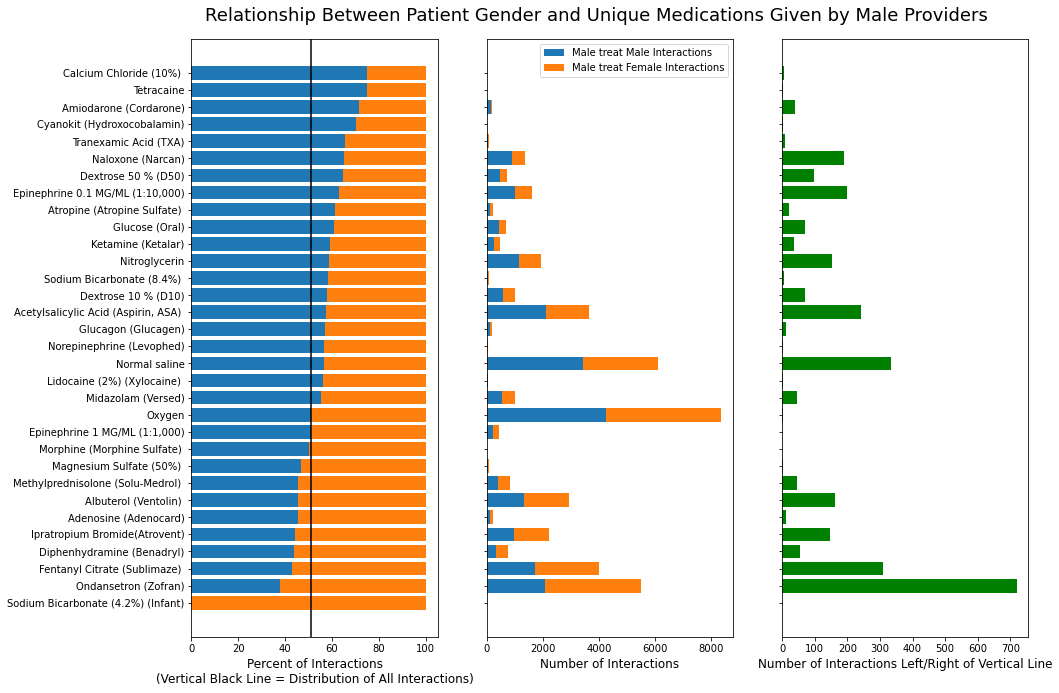

In [19]:
TripleBar(dfMedications,'Relationship Between Patient Gender and Unique Medications Given by Male Providers',
          'Interactions',interactionCount,
          'Male treat Male','Male Provider Dist of Male Patients','Male treat Male',
          'Male treat Female','Male Provider Dist of Female Patients','Male treat Female',
          'Number of Male Provider Interactions from Centerline',0)

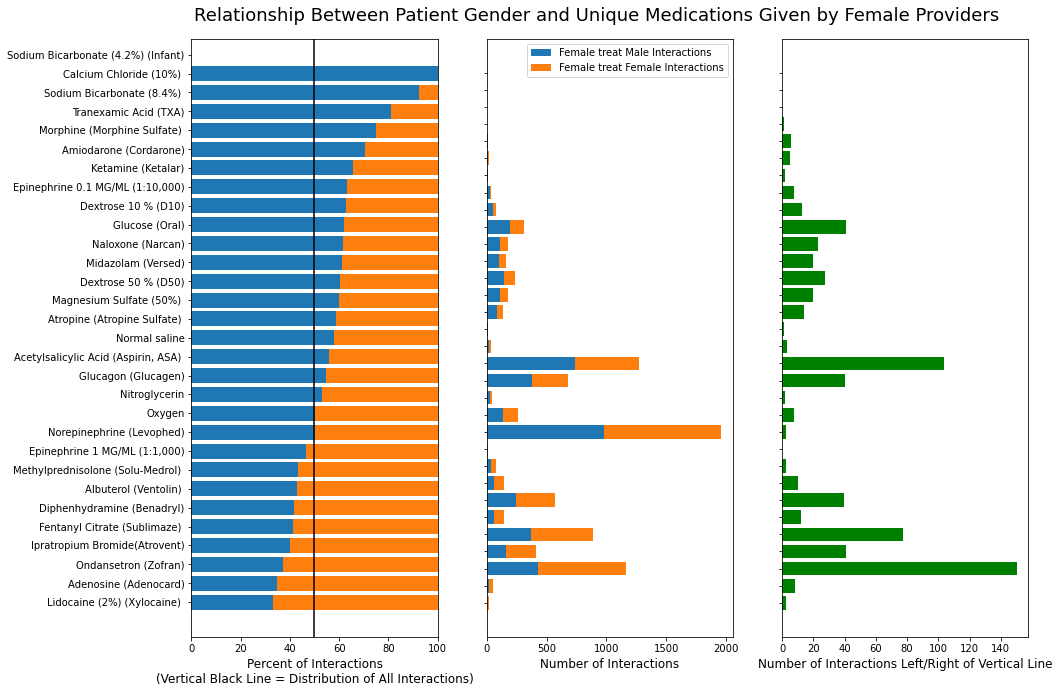

In [20]:
TripleBar(dfMedications,'Relationship Between Patient Gender and Unique Medications Given by Female Providers',
          'Interactions',interactionCount,
          'Female treat Male','Female Provider Dist of Male Patients','Female treat Male',
          'Female treat Female','Female Provider Dist of Female Patients','Female treat Female',
          'Number of Female Provider Interactions from Centerline',0)

### Are some medication classes given more to a certain gender patient?

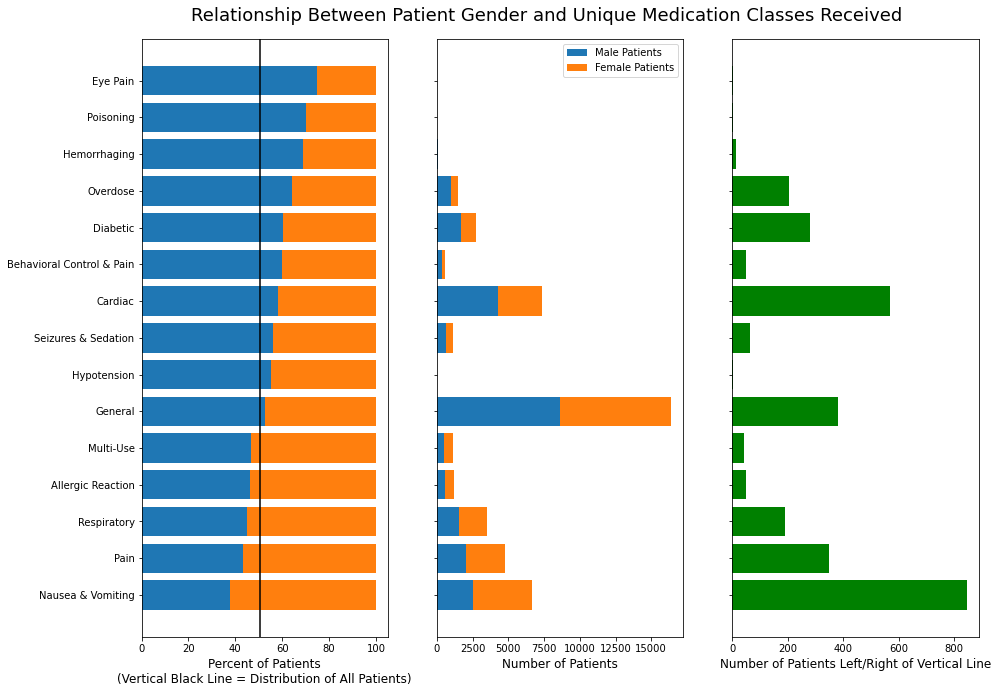

In [21]:
TripleBar(dfMedicationClasses,'Relationship Between Patient Gender and Unique Medication Classes Received',
          'Patients',patientCount,
          'Male','Dist Male Patients','Number of Male Patients',
          'Female','Dist Female Patients','Number of Female Patients',
          'Number of Patients from Centerline',0)

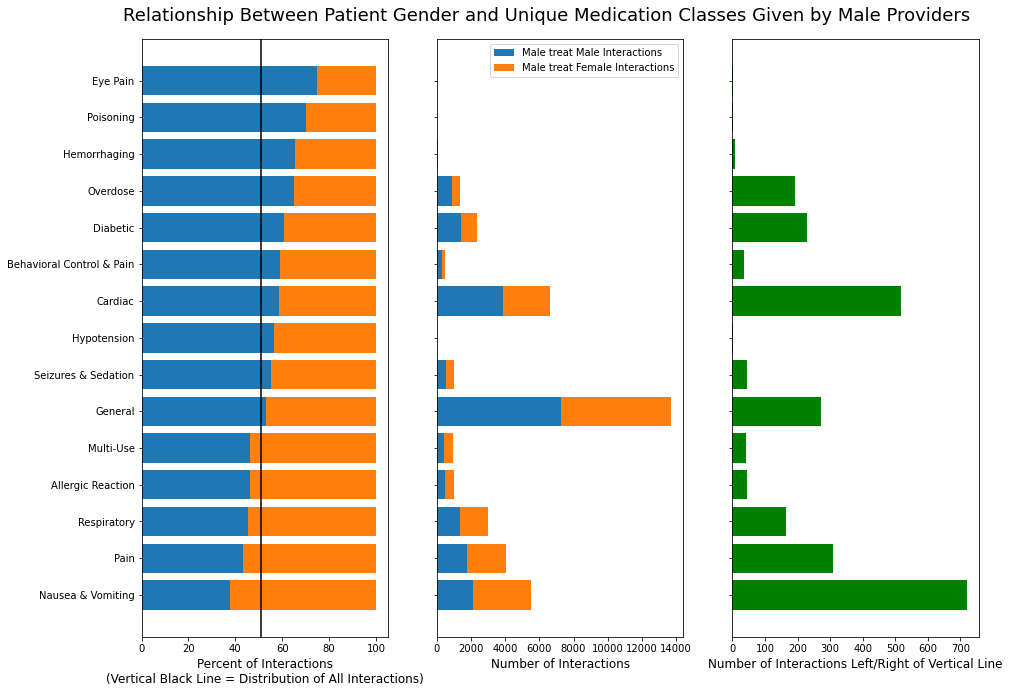

In [22]:
TripleBar(dfMedicationClasses,'Relationship Between Patient Gender and Unique Medication Classes Given by Male Providers',
          'Interactions',interactionCount,
          'Male treat Male','Male Provider Dist of Male Patients','Male treat Male',
          'Male treat Female','Male Provider Dist of Female Patients','Male treat Female',
          'Number of Male Provider Interactions from Centerline',0)

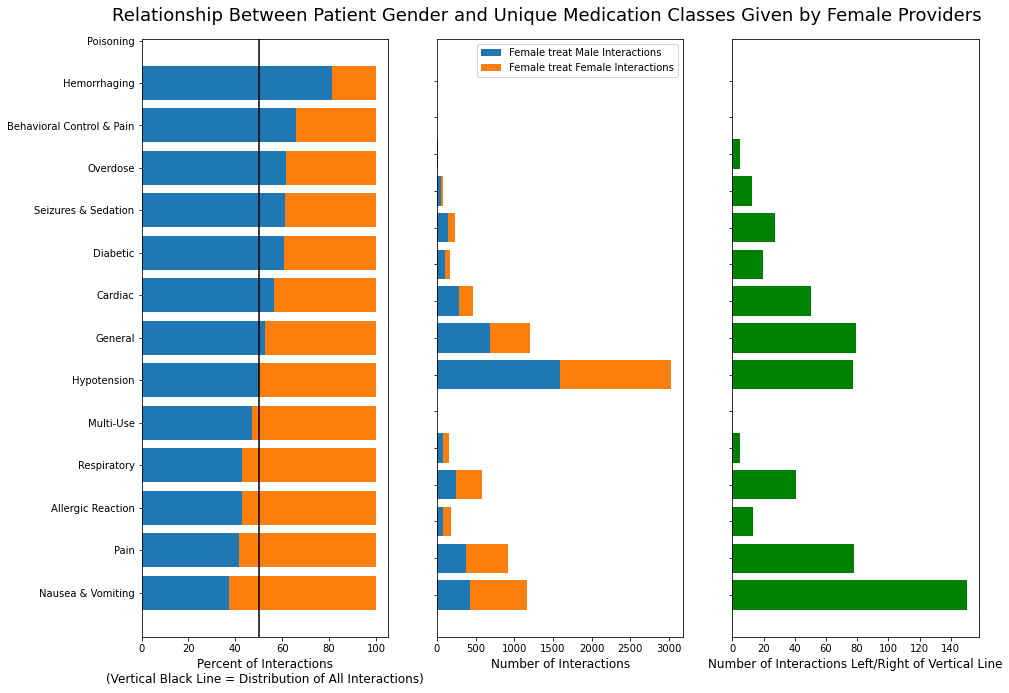

In [23]:
TripleBar(dfMedicationClasses,'Relationship Between Patient Gender and Unique Medication Classes Given by Female Providers',
          'Interactions',interactionCount,
          'Female treat Male','Female Provider Dist of Male Patients','Female treat Male',
          'Female treat Female','Female Provider Dist of Female Patients','Female treat Female',
          'Number of Female Provider Interactions from Centerline',0)

### Are some medications given more by a certain gender provider?

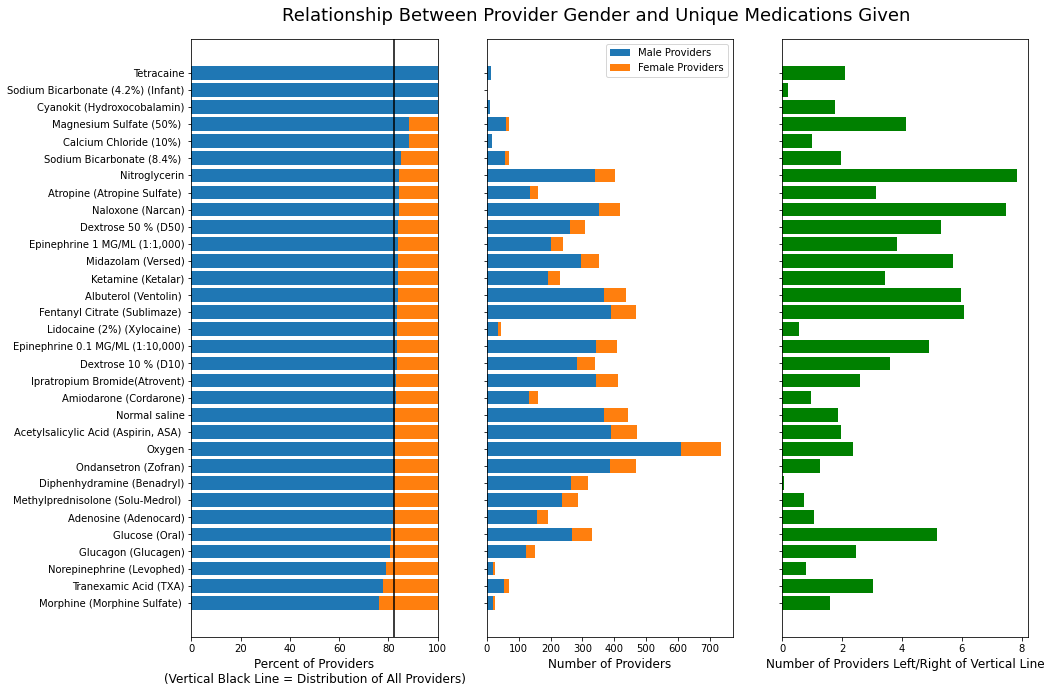

In [24]:
TripleBar(dfMedications,'Relationship Between Provider Gender and Unique Medications Given',
          'Providers',providerCount,
          'Male','Dist Male Providers','Number of Male Providers',
          'Female','Dist Female Providers','Number of Female Providers',
          'Number of Providers from Centerline',0)

For most of the medications, the percentage of male providers vs female providers is close to the overall percentage of male providers vs female providers. The tails at either end are associated with medications that have few instances. For example, Sodium Bicarbonate (Infant) was only given once, so it's value is 100%.

### Are some medication classes given more by certain gender providers?

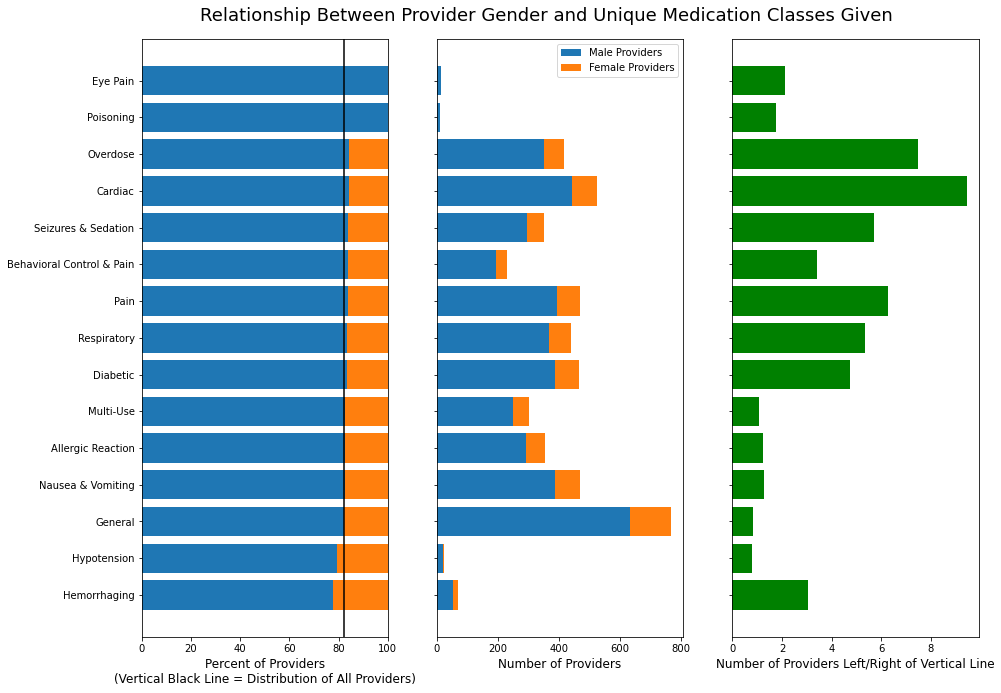

In [25]:
TripleBar(dfMedicationClasses,'Relationship Between Provider Gender and Unique Medication Classes Given',
          'Providers',providerCount,
          'Male','Dist Male Providers','Number of Male Providers',
          'Female','Dist Female Providers','Number of Female Providers',
          'Number of Providers from Centerline',0)

### Are the number of medications given related to the relationship between Provider and Patient Gender?
The number of medications given includes unique medications that were given more than once.

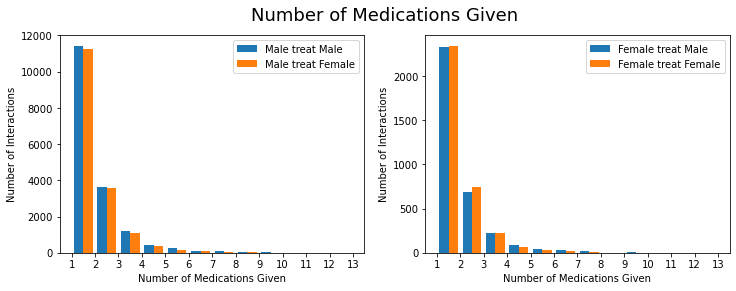

In [26]:
VertBars(dfInteractions,'NumMedicationsGiven',
         'Male treat Male','Male treat Female','Female treat Male','Female treat Female',
         'Number of Medications Given')

While the Female Providers number of interactions is much lower than that of Male Providers, the behavior by Male and Female Providers appears to be similar. They are scaled differently due to the ratio of Male to Female Providers in FCFRD.

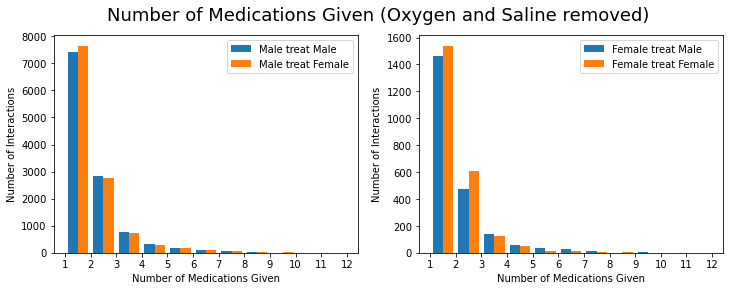

In [27]:
#Remove oxygen and saline (commonly given medications) and replot
VertBars(dfInteractionsNoGeneral,'NumMedicationsGiven',
         'Male treat Male','Male treat Female','Female treat Male','Female treat Female',
         'Number of Medications Given (Oxygen and Saline removed)')

### Are the number of unique medications given related to the relationship between Provider and Patient Gender?
If a unique medication is given more than once on a call, it is only captured once in this metric.

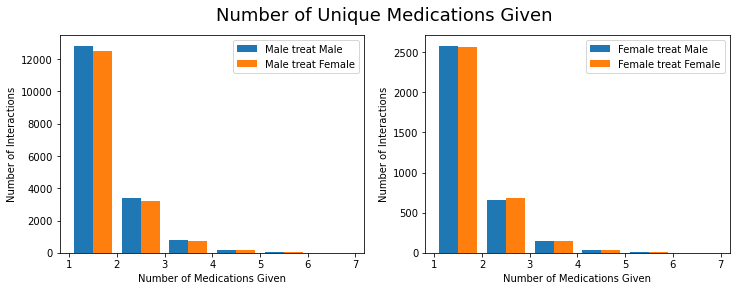

In [28]:
VertBars(dfInteractions,'NumUniqueMedicationsGiven',
         'Male treat Male','Male treat Female','Female treat Male','Female treat Female',
         'Number of Unique Medications Given')

The behavior in these histograms matches that of the Number of Medications Given histograms above. 

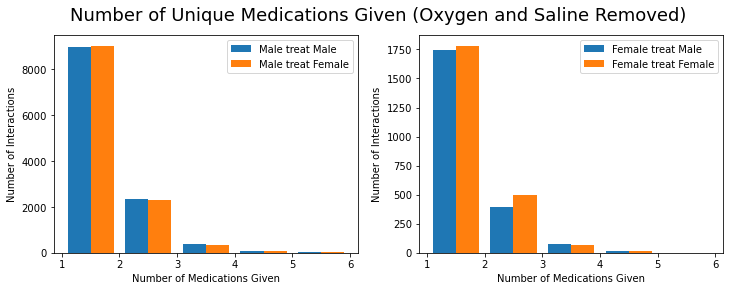

In [29]:
#Remove oxygen and saline (commonly given medications) and replot
VertBars(dfInteractionsNoGeneral,'NumUniqueMedicationsGiven',
         'Male treat Male','Male treat Female','Female treat Male','Female treat Female',
         'Number of Unique Medications Given (Oxygen and Saline Removed)')

### Are Providers likely to give medications to both Patient genders or are they biased towards a particular gender?

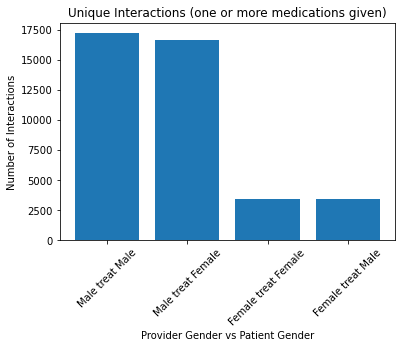

In [30]:
#For each unique interaction (Provider to Patient), plot the gender relationship
fig,ax=plt.subplots()
ax.bar(x=dfInteractions['GenderRelationship'].value_counts().index,height=dfInteractions['GenderRelationship'].value_counts())
ax.set_xlabel('Provider Gender vs Patient Gender')
ax.set_ylabel('Number of Interactions')
ax.set_title('Unique Interactions (one or more medications given)')
plt.xticks(rotation=45)
plt.show()

This bar chart indicates that Providers give medications to both Patient genders in a balanced fashion. This is useful background but probably not important to include in final analysis.

### Is giving a unique medication more than once related to the relationship between Provider and Patient Gender?

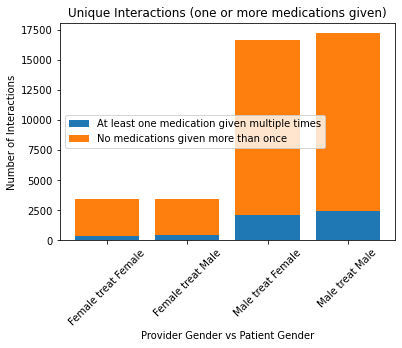

In [31]:
#For each unique interaction (Provider to Patient), plot the gender relationship vs whether or not at least one unique medication
#was given more than once
fig,ax=plt.subplots()
true=dfInteractions.loc[dfInteractions['MultiplesOfMedicationGiven']==True,:]
false=dfInteractions.loc[dfInteractions['MultiplesOfMedicationGiven']==False,:]
ax.bar(x=true['GenderRelationship'].value_counts().sort_index().index,height=true['GenderRelationship'].value_counts().sort_index())
ax.bar(x=false['GenderRelationship'].value_counts().sort_index().index,height=false['GenderRelationship'].value_counts().sort_index(),
      bottom=true['GenderRelationship'].value_counts().sort_index())
plt.xticks(rotation=45)
ax.set_xlabel('Provider Gender vs Patient Gender')
ax.set_ylabel('Number of Interactions')
ax.set_title('Unique Interactions (one or more medications given)')
plt.legend(['At least one medication given multiple times','No medications given more than once'],loc='center left')
plt.show()

Again, behavior doesn't seem to be impacted by gender. Although, I don't know if this metric is even relevant.